# LXE Solving
Here we solve for muons creating sound waves in liquid xenon. This is going to be great!

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from fem import *

# Load the text file with the properties of Xenon
prop_Xe = get_properties('./fluids/LXE.txt')
prop_mu = get_properties('./particles/muon.txt')

# Now we will define the appropriate constants in SI units
K       = prop_Xe['bulk_modulus']
c       = prop_Xe['sound_speed']
Cp      = prop_Xe['specific_heat_p']
beta    = prop_Xe['thermal_expansion']
mu      = prop_Xe['viscocity']
rho_0   = prop_Xe['rest_density']
I       = prop_Xe['ionization_potential']
Z       = prop_Xe['atomic_number']
M       = prop_Xe['molar_mass']
n       = rho_0/M*const.Avogadro                        # Particle density
s       = n**(-1/3)                                     # Inter-particle distance 
v       = prop_mu['speed']                              # Speed of particle
z       = prop_mu['charge']/const.elementary_charge     # Numer Charge of compound
cc      = const.c                                       # Speed of light
ne      = const.Avogadro * Z * rho_0/M                  # Electron Densiry
me      = const.electron_mass                           # Electron Mass
e       = -const.elementary_charge                      # Electron Charge
e0      = const.epsilon_0                               # Permitivity
bb      = v/cc                                          # Particle Relative speed

# dE/dx the bethe bloch formula for the particle
dEdx    = 4*np.pi/me * ne * z**2/v**2 *(e**2/(4*np.pi*e0))**2* (np.log(2*me*v**2/(I*(1-bb**2))) - bb**2)

# Control Constants
# They are scaling factors for the nondimensionalization
# To be altered each time so that to assist with the process
lam = 1e0
tau = 1e0

# Derived constants
w0      = K/mu                              # Attenuation Frequency
T       = tau/w0                            # Standard Time unit
L       = lam*T*c                           # Standard Length unit
P       = beta*v**2*L**3*T/(s**5*Cp)*dEdx   # Standard Pressure Unit

# Nondimensionalized source function
f = lambda r,z,t: (z-v*t*T/L) * np.exp(-(L/s)**2/2 *(r**2+ (z-v*t*T/L)**2))

In [2]:
# Here are the values for some characteristic constants for Xenon
print('''Physical Constants
--------------------------------------------''')
print('w0\t= %.3e Hz'%w0)
print('s\t= %.3e m'%s)
print('c\t= %.3e m/s'%c)
print('''
Simulation Constants
--------------------------------------------''')
print('T\t= %.3e s'%T)
print('L\t= %.3e m'%L)
print('P\t= %.3e Pa'%P)
print('''
Characteristic Source Constants
--------------------------------------------''')
print('std\t= %.3e L'%(s/L))
print('v\t= %.3e L/T'%(v*T/L))

Physical Constants
--------------------------------------------
w0	= 7.451e+10 Hz
s	= 4.189e-09 m
c	= 6.535e+02 m/s

Simulation Constants
--------------------------------------------
T	= 1.342e-11 s
L	= 8.770e-09 m
P	= 1.464e+05 Pa

Characteristic Source Constants
--------------------------------------------
std	= 4.776e-01 L
v	= 1.835e+05 L/T


In [3]:
# Now we have everything to create our numerical scheme so let's start

# Control variables
# These are the variables that control our simulation.
bounds  = [(0,1),(0,1)]             # Domain bounds
h       = 1e-2                      # Mesh Fineness parameter
FF      = lambda r,z: abs(1.3*r)    # Discretisation function
dt      = 1e-1                      # Simulation time step  

# Now we will get the mesh and points
# points,mesh = get_mesh_grid(h,bounds)
points,mesh = get_mesh(h,FF,bounds)
boundary    = get_boundary(points)

# Buld T, S matrices
TT,SS = get_TS(points,mesh)

# Construct the scheme matrix and apply boundary conditions
Ap= get_scheme_matrix(dt,TT,SS,tau=tau,lam=lam)
A = set_bc_lhs(boundary,Ap,points,mesh)

# Define the initial condition vectors
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
F      = np.array([f(*point,0) for point in points])

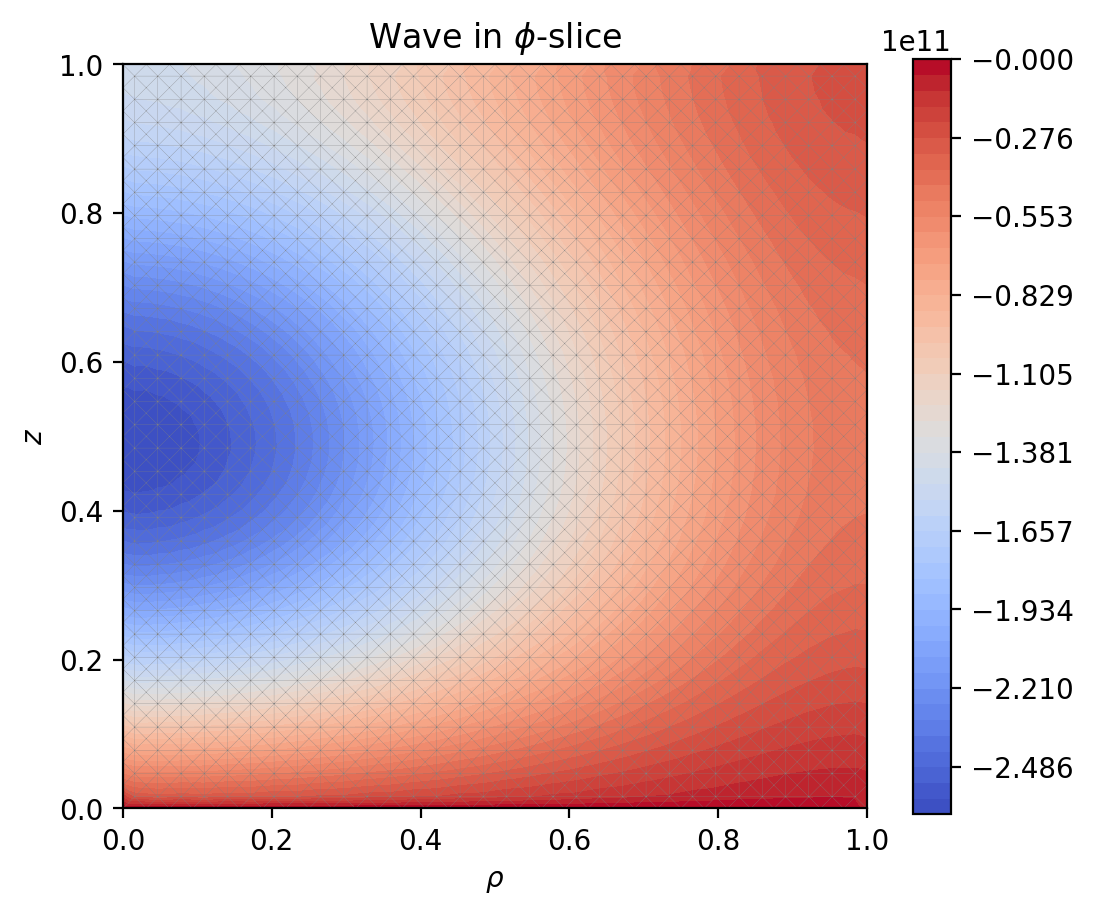

In [17]:
# Let's take one step in time and plot

U_curr = run(10*dt,dt,A,SS,TT,U_curr,U_prev,f,points,tau=tau,lam=lam);
plot_U(points,mesh,U_curr)

# U,_ = step(dt,A,SS,TT,U_curr,U_prev,F,tau=tau,lam=lam)
# plot_U(points,mesh,U)

4124306228.4336824

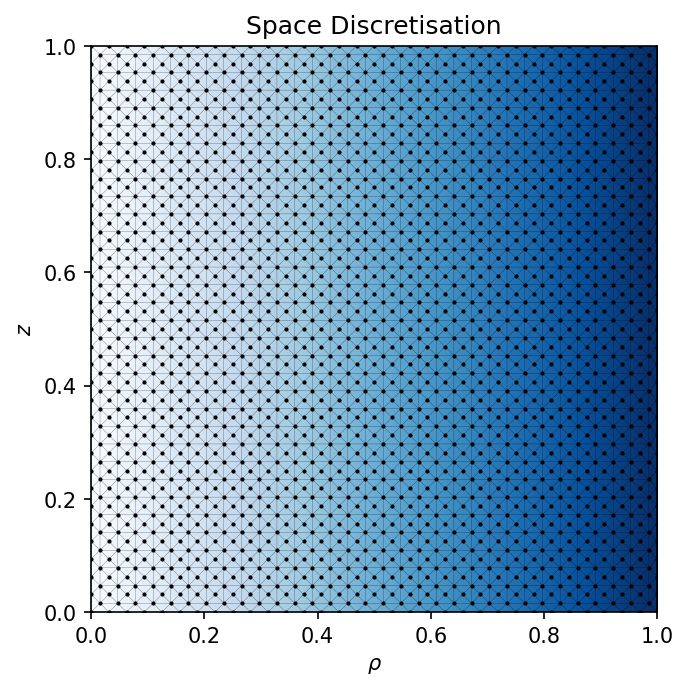

In [12]:
plot_mesh(points,mesh,FF);

In [6]:
points[0].min()

0.0

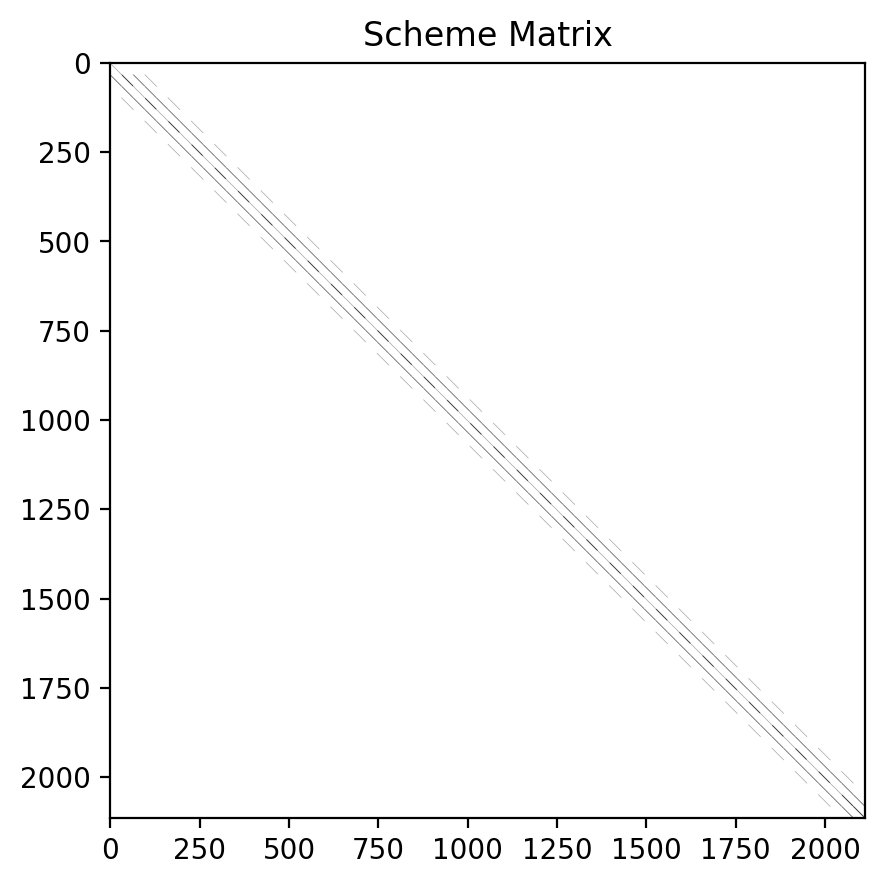

In [13]:
plot_A(Ap);

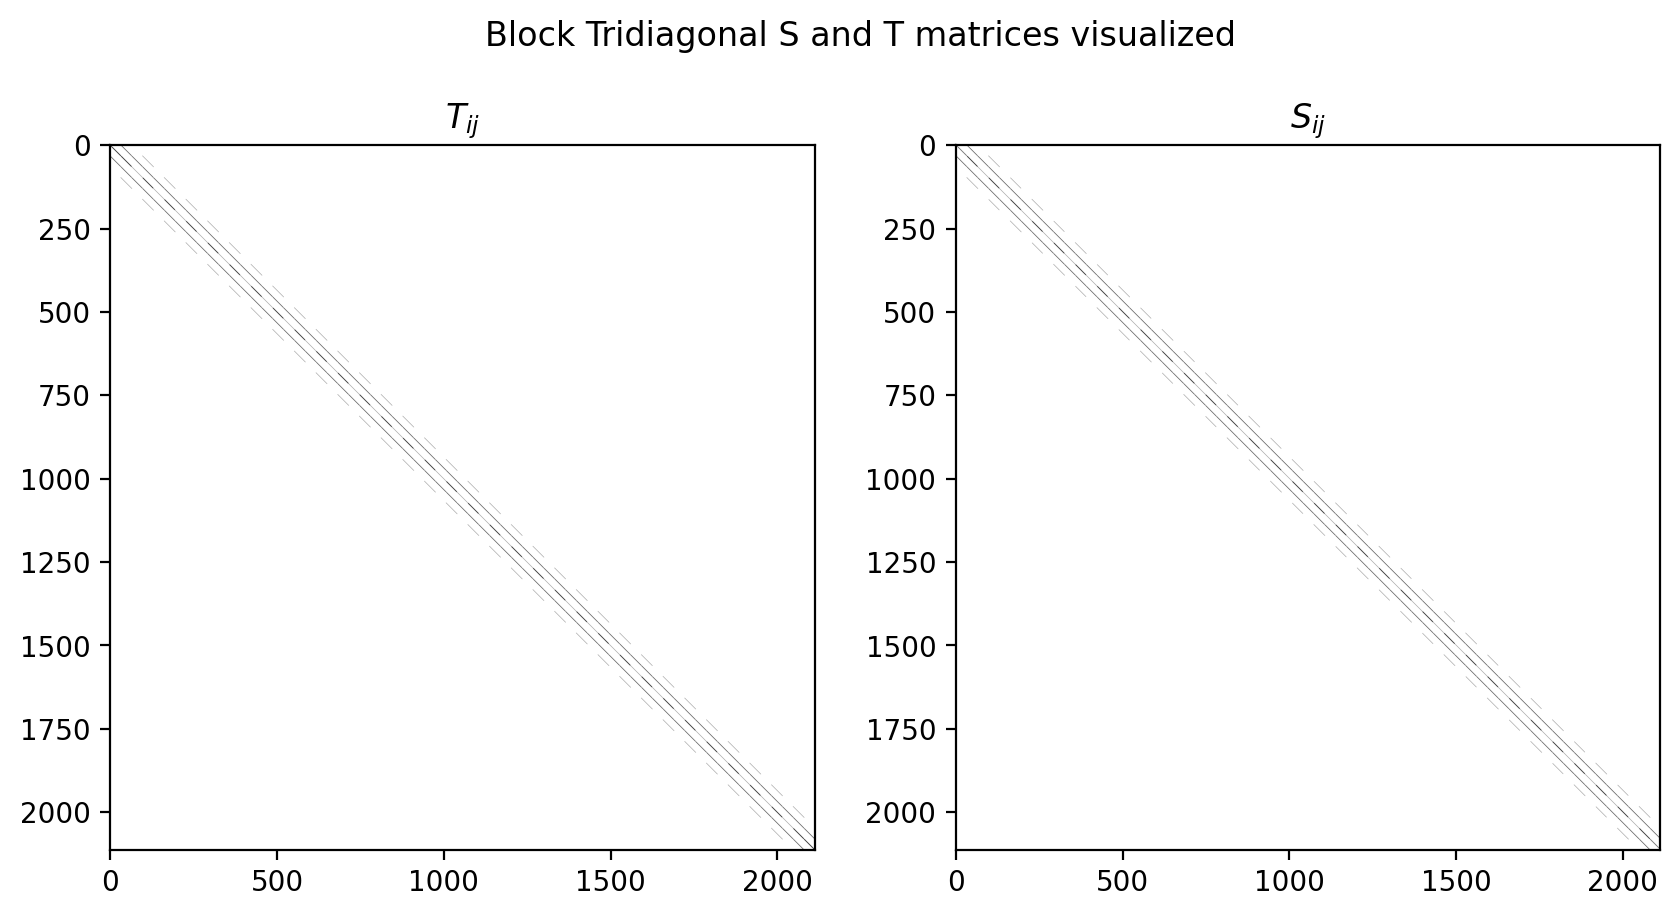

(<Figure size 2000x1000 with 2 Axes>,
 <AxesSubplot:title={'center':'$T_{ij}$'}>,
 <AxesSubplot:title={'center':'$S_{ij}$'}>)

In [8]:
plot_TS(SS,TT)

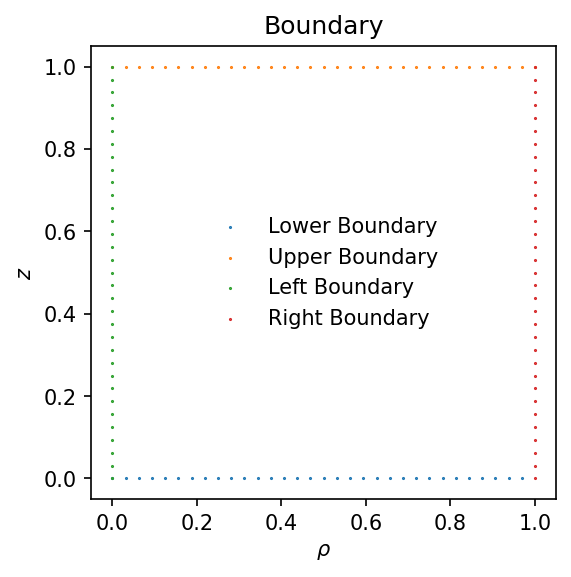

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot:title={'center':'Boundary'}, xlabel='$\\rho$', ylabel='$z$'>)

In [9]:
plot_boundary(boundary,points)